In [1]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re
import os

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

C:\Users\edufe\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Abre os dados

In [2]:
#Verifica os dados no diretorio

Data = os.listdir("../../Filter/Tweets_Filtered/")
for i in range(len(Data)):
    Data[i] = Data[i].split(".")[0]
    
Pessoas = ["realDonaldTrump", "jairbolsonaro", "hbredda", "gui_benchimol", "pedrocerize"]

NoticiasPolitica = ["OGloboPolitica", "folha_poder", "GloboNews", "EstadaoPolitica", 
                    "RevistaEpoca", "valoreconomico", "g1politica", "conexaopolitica", "EstadaoEconomia", 
                    "UOLEconomia", "folha_mercado", "g1economia", "OGlobo_Economia"]

Noticias = ["UOL", "folha", "g1", "VEJA", "cartacapital", "RevistaISTOE"]

#Monta um dicionario com todos datasets de twites de todas as pessoas
Alvo = NoticiasPolitica


AllData = pd.DataFrame()
for i in Alvo:
    if i in Data:
        MoreData = pd.read_csv("../../Filter/Tweets_Filtered/{0}".format(i+".csv"), sep=";", decimal=",", encoding='utf-16')
        AllData = pd.concat([AllData, MoreData])
    else:
        print("{0} não disponivel".format(i))
        
AllData = AllData.reset_index(drop=True)

In [3]:
label_encoder = LabelEncoder()

label_encoder.fit(AllData.Pessoa)
AllData['Pessoa_id'] = label_encoder.transform(AllData.Pessoa)

In [4]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id
40177,OGlobo_Economia,2017-02-01 10:10:01,consumidor terá que pagar a conta de indenizaç...,6,10,1,4
4855,folha_poder,2019-01-24 20:00:03,assessor do planalto em davos já fez campanha ...,3,4,1,9
39871,OGlobo_Economia,2017-02-17 11:00:02,em coluna pedro doria comenta a trajetória do ...,1,2,1,4
6158,folha_poder,2018-11-21 04:05:03,a sala vermelha da tortura,30,54,1,9
20095,g1politica,2019-03-12 20:22:12,inquérito da pf que apura suposta obstrução no...,6,26,1,11


In [5]:
document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 13.991752676762806.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 30.


In [6]:
smallerthen4 = document_lengths <= 5

for i in range(len(document_lengths)):
    if smallerthen4[i]:
        AllData = AllData.drop(i)

document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['document_sentences'] = df.Texto.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(sentences),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(AllData)

In [9]:
def lda_get_good_tokens(df):
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.Texto))
    df['tokenized_text'] = list(df.tokenized_text)

lda_get_good_tokens(AllData)

In [10]:
tokenized_only_dict = Counter(np.concatenate(AllData.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

tokenized_only_df.sort_values('count', ascending=False, inplace=True)

In [11]:
print(nltk.corpus.stopwords.words('portuguese')[0:20])

['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as']


In [12]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('portuguese')[0:20]
    
    del(stopwords[stopwords.index("não")])
    ManualStop = ["istoégente", "expressoepoca", "globonews", "estudioi", "rt", "andreiasadi",
                  "’", "‘", "”", "“", "r", ",", ".", "…", "diz", "à", "ao"]
    Numbers = list(range(10))
    stopwords = stopwords + ManualStop + Numbers
    
    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(AllData)

In [13]:
#Não Funciona em PT

def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

In [14]:
dictionary = Dictionary(documents=AllData.stopwords_removed.values)

print("Found {} words.".format(len(dictionary.values())))

Found 29532 words.


In [15]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 12050 words.


In [16]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stopwords_removed))
    
document_to_bow(AllData)

In [17]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    document_to_bow(df)

# Análise de tópicos

In [18]:
corpus = AllData.bow

In [19]:
num_topics = 20
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=11,
                        chunksize=10000,
                        iterations = 5,
                        passes=7,
                        alpha='asymmetric')

In [20]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

AllData['lda_features'] = list(map(lambda doc:
                              document_to_lda_features(LDAmodel, doc),
                              AllData.bow))

In [23]:
topic_distribution = []
for i in Alvo:
    topic_distribution.append(AllData.loc[AllData.Pessoa == i, 'lda_features'].mean())

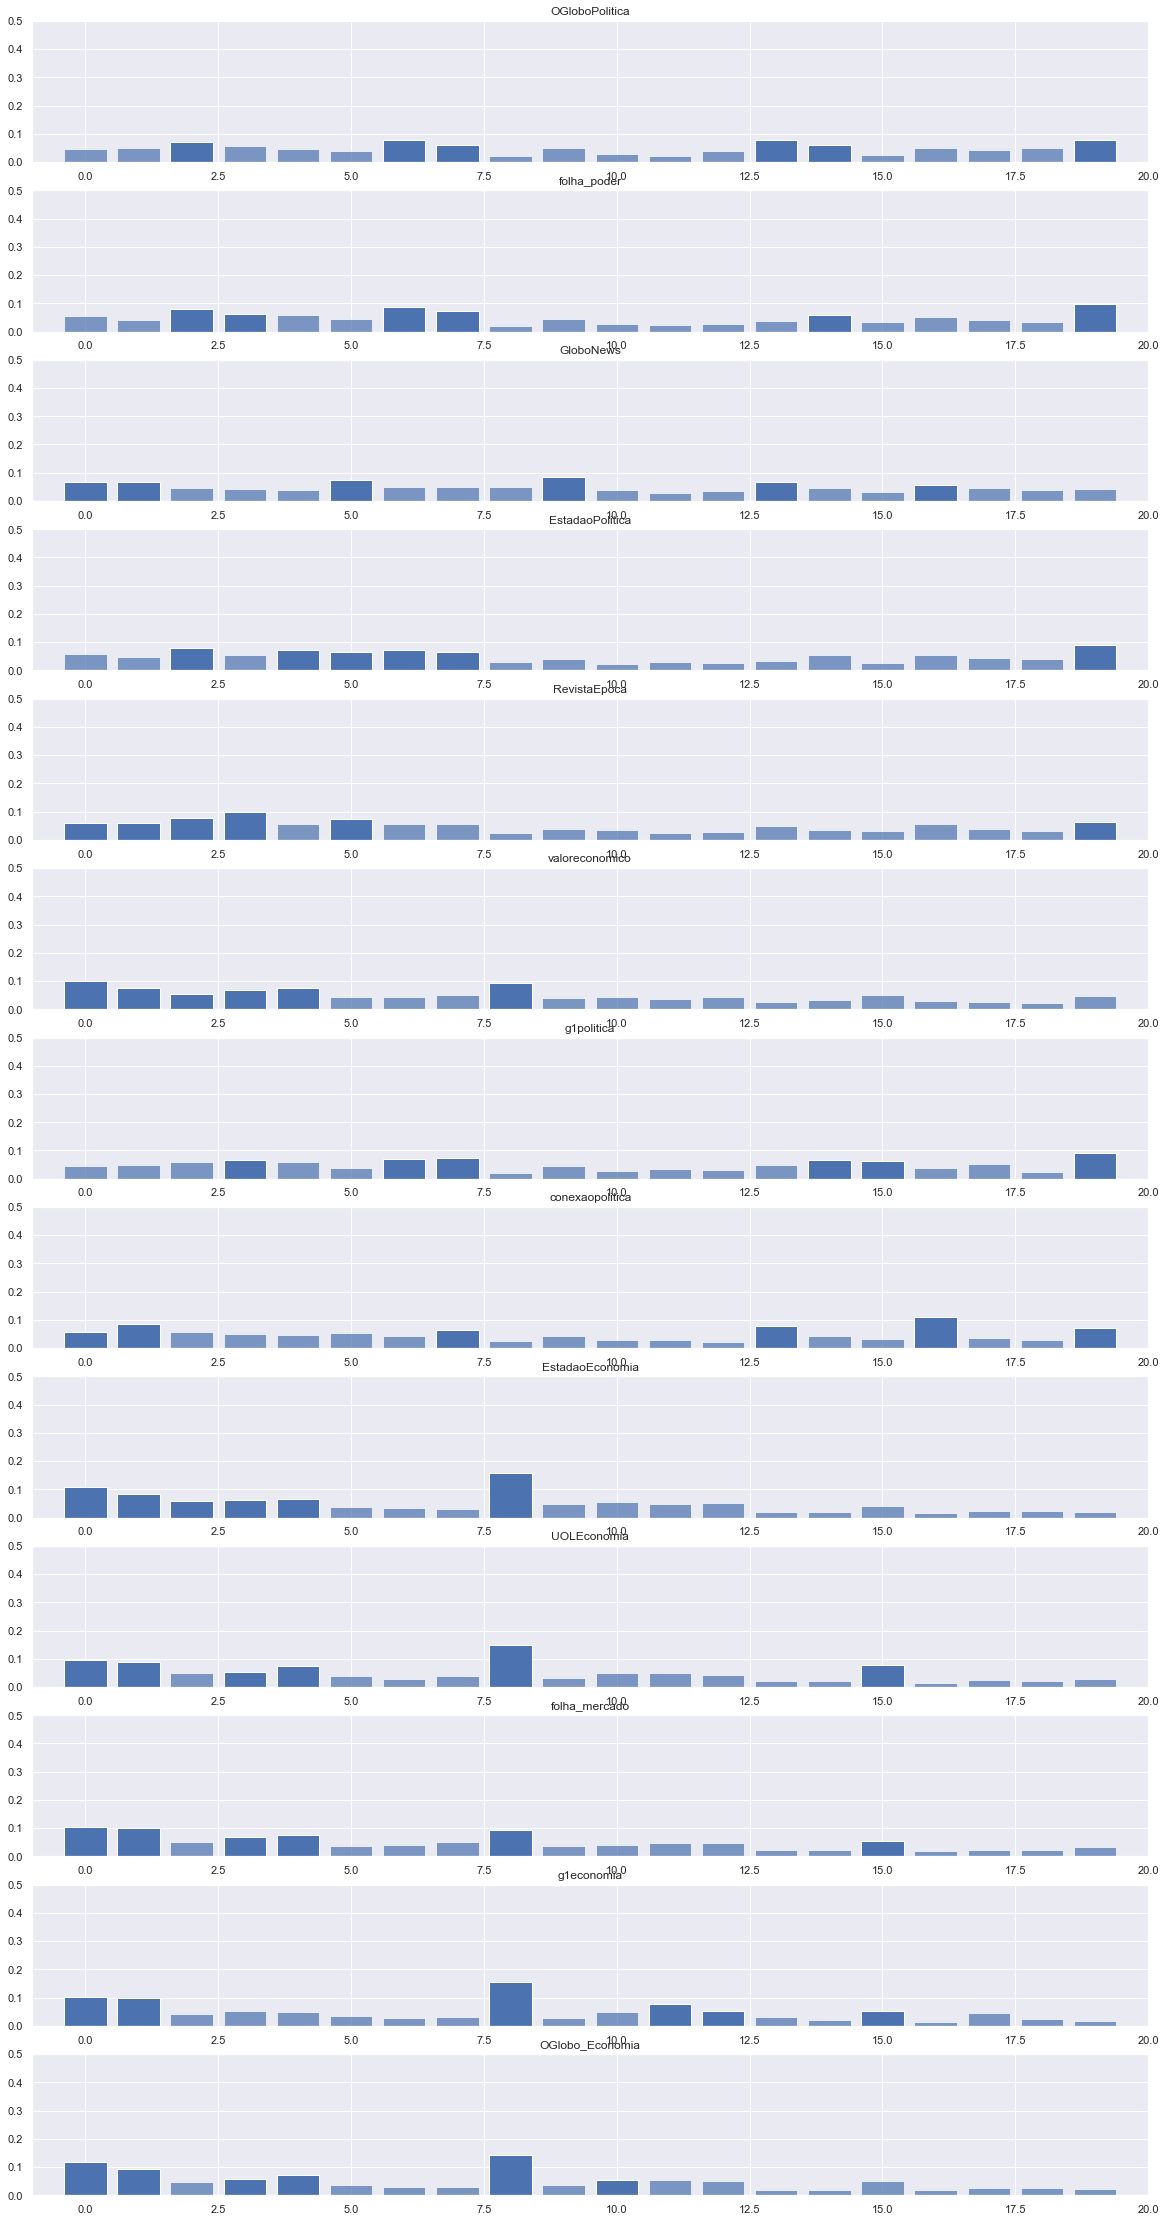

In [24]:
ax = 0

Axes = [ax]*len(Alvo)
fig, Axes = plt.subplots(len(Alvo),figsize=(20,40))

nr_top_bars = 6

for i in range(len(Axes)):
    Axes[i].set_title(Alvo[i])

for ax, distribution in zip(Axes, topic_distribution):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, num_topics)
    ax.set_ylim(0,0.5)

In [25]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,bow,lda_features
22799,conexaopolitica,2019-04-06 14:17:45,5 como vocês sabem nós da mídia independente n...,235,1105,1,7,[5 como vocês sabem nós da mídia independente ...,"[[5, como, vocês, sabem, nós, da, mídia, indep...","[5, como, vocês, sabem, nós, da, mídia, indepe...","[5, como, vocês, sabem, nós, mídia, independen...","[(24, 1), (113, 1), (127, 1), (769, 1), (1096,...","[0.011616748757660389, 0.006788869388401508, 0..."
12665,EstadaoPolitica,2018-05-15 22:45:00,gilmar critica redução de foro mas baixa proce...,7,16,1,1,[gilmar critica redução de foro mas baixa proc...,"[[gilmar, critica, redução, de, foro, mas, bai...","[gilmar, critica, redução, de, foro, mas, baix...","[gilmar, critica, redução, foro, mas, baixa, p...","[(12, 1), (67, 1), (95, 1), (96, 1), (186, 1),...","[0.012554911896586418, 0.01018553227186203, 0...."
23237,conexaopolitica,2019-03-06 21:02:36,últimas lava jato pede suspeição de gilmar men...,1088,3510,1,7,[últimas lava jato pede suspeição de gilmar me...,"[[últimas, lava, jato, pede, suspeição, de, gi...","[últimas, lava, jato, pede, suspeição, de, gil...","[últimas, lava, jato, pede, suspeição, gilmar,...","[(196, 1), (298, 1), (299, 1), (445, 1), (446,...","[0.012458895333111286, 0.010180950164794922, 0..."
31552,UOLEconomia,2018-12-20 22:20:07,temer sanciona lei que cria duplicata eletrônica,2,7,1,6,[temer sanciona lei que cria duplicata eletrôn...,"[[temer, sanciona, lei, que, cria, duplicata, ...","[temer, sanciona, lei, que, cria, duplicata, e...","[temer, sanciona, lei, cria, duplicata, eletrô...","[(49, 1), (595, 1), (938, 1), (1011, 1), (4528...","[0.020770296454429626, 0.01697337068617344, 0...."
20783,g1politica,2019-02-02 22:36:13,onyx ganha fôlego com vitória anti renan mas m...,35,154,1,11,[onyx ganha fôlego com vitória anti renan mas ...,"[[onyx, ganha, fôlego, com, vitória, anti, ren...","[onyx, ganha, fôlego, com, vitória, anti, rena...","[onyx, ganha, fôlego, vitória, anti, renan, ma...","[(67, 1), (135, 1), (236, 1), (351, 1), (1370,...","[0.024905985221266747, 0.009266184642910957, 0..."


In [26]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model."""
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [27]:
from pprint import pprint

print("Looking up top words from top topics")
for x in range(num_topics):
    top_words = get_topic_top_words(LDAmodel, x, nr_top_words=50)
    pprint(f"For topic {x+1}, the top words are:")
    pprint("{0}".format(", ".join(top_words)))
    pprint("")
print("")

Looking up top words from top topics
'For topic 1, the top words are:'
('é, brasil, empresas, não, bolsonaro, governo, após, sobre, trump, '
 'presidente, crescimento, 2, das, justiça, país, 2019, como, energia, '
 'previdência, norte, eleitoral, sul, está, novos, estadão, compra, novo, '
 'entre, são, ser, queda, mundo, tem, trimestre, reforma, 1, foi, 1º, leilão, '
 'venda, mas, 2018, dos, pelo, milhões, anos, rio, até, tesouro, argentina')
''
'For topic 2, the top words are:'
('eua, dos, china, nos, é, brasil, sobre, foi, acordo, não, entre, mercado, '
 'governo, stf, prisão, tem, das, mas, após, últimas, setor, trabalho, ações, '
 'vê, são, temer, carne, vivo, contra, comercial, mundo, instância, venda, '
 'risco, faz, como, pela, projeto, aponta, processo, país, sem, jairbolsonaro, '
 'dias, empresas, trump, nova, lei, vai, mínimo')
''
'For topic 3, the top words are:'
('bolsonaro, governo, não, moro, é, presidente, dos, ter, quer, sobre, pode, '
 'sem, sp, ser, câmara, ministro, 

In [28]:
TopicsData = np.array(list(AllData["lda_features"]))
TopicsData = np.transpose(TopicsData)

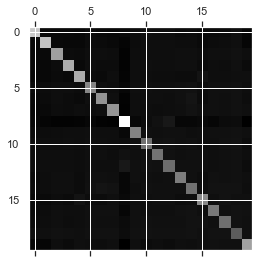

In [29]:
CovMatrix = np.cov(TopicsData)
plt.matshow(CovMatrix, cmap=plt.cm.gray)
plt.show()

## Word2Vec

In [30]:
sentences = []
for sentence_group in AllData.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(AllData)))

Number of sentences: 41073.
Number of texts: 41073.


In [31]:
# Set values for various parameters
num_features = 100    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 11      # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

In [32]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

AllData['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      AllData.tokenized_sentences))

C:\Users\edufe\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [33]:
w2vec_distribution = []
for i in Alvo:
    w2vec_distribution.append(AllData.loc[AllData.Pessoa == i, 'w2v_features'].mean())

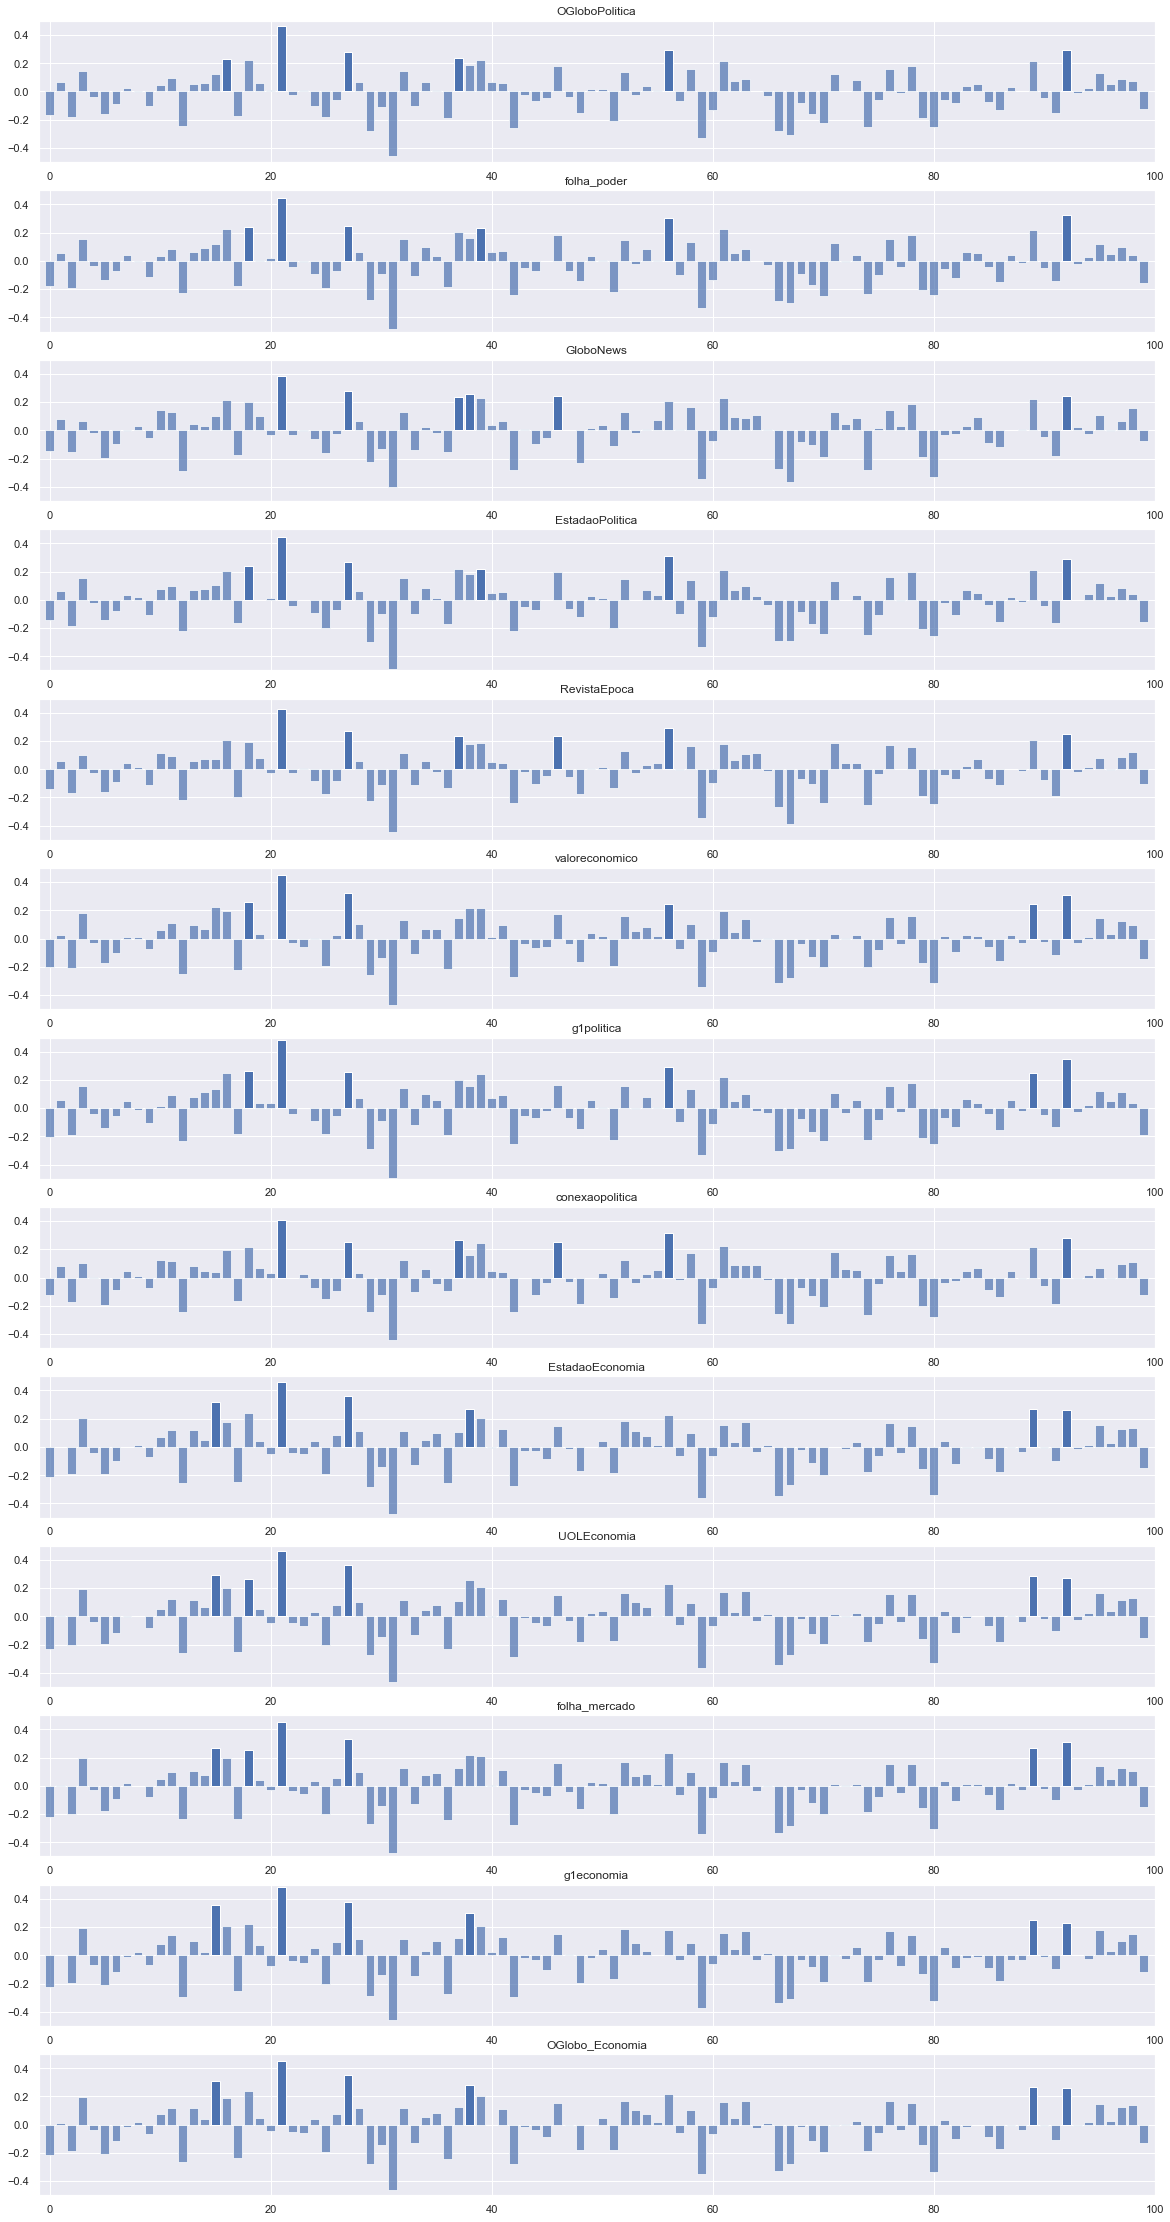

In [34]:
Axes = [ax]*len(Alvo)
fig, Axes = plt.subplots(len(Alvo),figsize=(20,40))

nr_top_bars = 6

for i in range(len(Axes)):
    Axes[i].set_title(Alvo[i])

for ax, distribution in zip(Axes, w2vec_distribution):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, num_features)
    ax.set_ylim(-0.5,0.5)

## Filtra as ações

In [35]:
Stocks = ["ibov", "ITUB4", "PETR4", "Vale3", "BBDC4", "ABEV3", "BBAS3", "SANB3", "LREN3"]

Cols = {}
for i in range(len(Stocks)):
    Cols[Stocks[i]] = [i*4+i, i*4+i+1, i*4+i+2, i*4+i+3]

In [37]:
Var = 'ibov'
bolsa = pd.read_excel('../../Dados_Bolsa/Twt.xlsx', sheet_name="1h", usecols=Cols[Var],  skiprow=[0])

In [38]:
headers = list(bolsa.keys())
myheaders = [Var, "Price", "Volume", "Ticks"]

for i in range(len(headers)):
    bolsa.rename(columns={headers[i]: myheaders[i]}, inplace=True)
    
bolsa = bolsa.dropna()
bolsa.drop(bolsa.head(1).index,inplace=True)

bolsa = bolsa.reset_index(drop=True)

In [39]:
bolsa.head(5)

,ibov,Price,Volume,Ticks
0,2018-10-08 10:00:00,86283.7,0,119
1,2018-10-08 11:00:00,85686.7,0,120
2,2018-10-08 12:00:00,85408.6,0,120
3,2018-10-08 13:00:00,85267.7,0,120
4,2018-10-08 14:00:00,85686.7,0,120


In [41]:
ibov_len  = len(bolsa[Var])
ibov_len

1110

In [42]:
import datetime

ibov_data_precos = {}
DeadZoneUp = 0.3e-2
DeadZoneDown = 0.6e-2
# célula para identificar os preços de abertura e fechamento de cada dia
for i in range(0, ibov_len):
    data_completa = datetime.datetime.strptime(str(bolsa[Var][i]), '%Y-%m-%d %H:%M:%S')
    preco = bolsa['Price'][i]
    data = data_completa.strftime("%Y-%m-%d")
    if data not in ibov_data_precos:
        ibov_data_precos[data] = {}
        ibov_data_precos[data]['abertura'] = preco
        #caso só tenhamos informação de uma hora dentro de um dia, assumimos esse preco como o de fechamento tbm
        ibov_data_precos[data]['fechamento'] = preco 
        dia_anterior_completo =  data_completa - datetime.timedelta(days=1)
        dia_anterior_data = dia_anterior_completo.strftime("%Y-%m-%d")
        
        if(dia_anterior_data in ibov_data_precos):
            dia_anterior_fechamento = ibov_data_precos[dia_anterior_data]['fechamento']
            
            if(preco > dia_anterior_fechamento + dia_anterior_fechamento*DeadZoneUp):
                ibov_data_precos[data]['variacao'] = 2 #Subiu
            elif (preco < dia_anterior_fechamento - dia_anterior_fechamento*DeadZoneDown):
                ibov_data_precos[data]['variacao'] = 0 #Desceu
            else:
                ibov_data_precos[data]['variacao'] = 1
        else:
            #se não tivermos informações sobre o dia anterior, assumimos que a variacao foi neutra
            ibov_data_precos[data]['variacao'] = 0 
    else:
        if i < (ibov_len - 1):
            data_seguinte = datetime.datetime.strptime(str(bolsa[Var][i+1]), '%Y-%m-%d %H:%M:%S')
            if data_seguinte.date() > data_completa.date():
                ibov_data_precos[data]['fechamento'] = preco

Datesibov = list(ibov_data_precos.keys())
                
for i in range(4):
    print(Datesibov[i], ibov_data_precos[Datesibov[i]])

2018-10-08 {'abertura': 86283.67, 'fechamento': 86083.91, 'variacao': 0}
2018-10-09 {'abertura': 85864.42, 'fechamento': 86087.55, 'variacao': 1}
2018-10-10 {'abertura': 84590.04, 'fechamento': 83679.11, 'variacao': 0}
2018-10-11 {'abertura': 84492.8, 'fechamento': 82921.08, 'variacao': 2}


## Cria os Datasets

In [43]:
OutputData = []
InputData = []
for i in range(len(AllData)):
    data_completa = datetime.datetime.strptime(str(AllData["Data"].iloc[i]), '%Y-%m-%d %H:%M:%S')
    data = data_completa.strftime("%Y-%m-%d")
    if data in list(ibov_data_precos.keys()):
        OutputData.append(ibov_data_precos[data]["variacao"])
        ThisLine = list(AllData['w2v_features'].iloc[i])
        ThisLine = ThisLine + list(AllData['lda_features'].iloc[i])
        ThisLine.append(AllData['Retweets'].iloc[i])
        ThisLine.append(AllData['Likes'].iloc[i])
        ThisLine.append(AllData['Pessoa_id'].iloc[i])
        InputData.append(ThisLine)

In [44]:
len(OutputData), len(InputData), len(InputData[0])

(26261, 26261, 123)

In [45]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_classes, test_classes = train_test_split(InputData, OutputData, 
                                                                        test_size=0.1, stratify=OutputData)

## Distribuição das Classes:

In [46]:
trainlen = len(train_classes)
testlen = len(test_classes)

print("Treinamento:")
print(train_classes.count(0)/trainlen)
print(train_classes.count(1)/trainlen)
print(train_classes.count(2)/trainlen)
print()
print("Teste:")
print(test_classes.count(0)/testlen)
print(test_classes.count(1)/testlen)
print(test_classes.count(2)/testlen)

Treinamento:
0.3266903613438267
0.38072268765338074
0.2925869510027926

Teste:
0.32660829843928435
0.3806623524933384
0.29272934906737724


## Aplicação de Modelos

In [47]:
from sklearn.model_selection import cross_val_predict, cross_val_score

### Regressão Logistica

In [48]:
from sklearn.linear_model import LogisticRegression

Losgisticclf = LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1)

scores = cross_val_score(Losgisticclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.35259852 0.36349098 0.38082724]
0.3656389100587862


### Decision Tree

In [49]:
from sklearn import tree

tree = tree.DecisionTreeClassifier()

scores = cross_val_score(tree, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.3335237  0.3594928  0.35637569]
0.34979739652998143


### Randon Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

RandonForestclf = RandomForestClassifier(n_estimators=10, n_jobs=-1)

scores = cross_val_score(RandonForestclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.35762421 0.37548549 0.37797075]
0.37036015220791835


In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10, 30, 100], 
    'min_impurity_decrease': [1e-5, 1e-6, 0]}
  ]

RandonForestclf = RandomForestClassifier(n_estimators=10, min_impurity_decrease=1e-3)

grid_search = GridSearchCV(RandonForestclf, param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)

grid_search.fit(InputData, OutputData)

print(grid_search.best_params_, grid_search.best_score_)

BestParams = grid_search.best_params_

RandonForestclf = RandomForestClassifier(n_estimators=BestParams["n_estimators"], 
                                         min_impurity_decrease=BestParams["min_impurity_decrease"])

C:\Users\edufe\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\edufe\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\edufe\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\edufe\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706

KeyboardInterrupt: 

## Best Model

In [53]:
TopClassifier = RandonForestclf

y_pred = cross_val_predict(TopClassifier, InputData, OutputData, cv=3)

In [54]:
Output_Pred = list(y_pred)

print("Resultado Modelo:")
print(Output_Pred.count(0)/len(Output_Pred))
print(Output_Pred.count(1)/len(Output_Pred))
print(Output_Pred.count(2)/len(Output_Pred))

Resultado Modelo:
0.39739537717527895
0.39876623129355315
0.2038383915311679


In [55]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(OutputData, Output_Pred)
conf_mx

array([[3636, 3327, 1616],
       [3877, 4172, 1949],
       [2923, 2973, 1788]], dtype=int64)

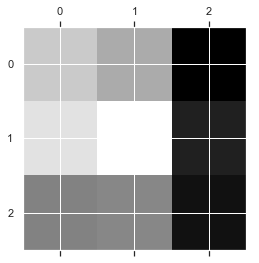

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
InputDataa = np.array(InputData)
OutputDataa = np.array(OutputData)
Output_Preda = np.array(Output_Pred)

In [58]:
AllResults = pd.DataFrame(InputData)
AllResults["Output"]= OutputDataa
AllResults["Output_pred"]= Output_Preda

AllResults.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,Output,Output_pred
6232,-0.163184,0.067277,-0.081655,0.249035,-0.129505,-0.228579,-0.190861,-0.005570,-0.090909,-0.174360,...,0.003576,0.003402,0.003243,0.003099,0.002967,1,8,2,1,0
24653,0.206652,0.008836,-0.280376,0.104473,-0.283103,-0.085119,0.075474,0.093112,-0.005372,0.063240,...,0.004768,0.004535,0.004324,0.004132,0.003956,0,3,10,0,0
526,-0.109810,0.042050,-0.135769,0.120343,0.013509,-0.083434,-0.028202,0.097826,0.076464,-0.109996,...,0.128452,0.002721,0.002594,0.002479,0.002373,8,13,3,1,2
21871,-0.184410,-0.028167,-0.116620,0.301503,0.000185,-0.314271,-0.130589,-0.043704,-0.092016,-0.099059,...,0.002861,0.002721,0.002594,0.537685,0.002373,1,4,8,2,1
1993,-0.343928,0.056764,-0.272822,0.294210,-0.028301,-0.215303,-0.103288,0.145014,-0.095401,-0.075342,...,0.004087,0.003887,0.003706,0.160515,0.174684,66,250,3,1,0


In [59]:
ResultCorr = np.array(AllResults.corr())
AllResults.corr()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,Output,Output_pred
0,1.000000,0.289813,0.320446,-0.012276,0.141703,0.071935,0.065383,0.194089,0.339585,0.143260,...,-0.304152,0.134895,-0.120215,0.043496,-0.058582,0.072556,0.069369,-0.146266,0.015388,0.000656
1,0.289813,1.000000,0.140271,-0.215658,0.153404,0.056999,0.021399,0.140097,0.104862,-0.032540,...,0.025669,0.133705,-0.119195,0.010900,0.124952,0.075838,0.090036,-0.146549,0.006135,0.021355
2,0.320446,0.140271,1.000000,-0.289884,0.111638,-0.038838,0.221710,0.003284,-0.090116,0.054876,...,0.049000,0.070006,0.011267,0.013885,-0.155819,0.006122,-0.004723,-0.108425,0.022172,0.047610
3,-0.012276,-0.215658,-0.289884,1.000000,-0.135389,-0.037498,-0.336089,0.068770,0.034524,-0.038094,...,-0.134343,-0.098785,-0.149030,-0.127441,-0.017735,-0.036951,-0.031806,0.170445,-0.000374,-0.007953
4,0.141703,0.153404,0.111638,-0.135389,1.000000,-0.269287,0.087382,0.153819,0.019879,0.220488,...,0.070884,0.014866,-0.131251,0.129090,0.074346,0.046039,0.059340,-0.066017,-0.021029,-0.043558
5,0.071935,0.056999,-0.038838,-0.037498,-0.269287,1.000000,0.370678,0.355517,0.048602,-0.266964,...,0.028530,0.054109,0.023872,-0.089834,0.132261,0.005100,-0.004155,0.027476,0.046713,0.088011
6,0.065383,0.021399,0.221710,-0.336089,0.087382,0.370678,1.000000,0.416806,-0.042139,-0.055057,...,0.080795,0.032250,0.088819,0.002825,0.023225,0.008436,0.007518,0.009613,0.046492,0.102588
7,0.194089,0.140097,0.003284,0.068770,0.153819,0.355517,0.416806,1.000000,-0.089039,-0.091418,...,-0.018602,0.009496,0.002287,-0.069261,0.129552,0.052007,0.065720,0.021161,0.019651,0.041887
8,0.339585,0.104862,-0.090116,0.034524,0.019879,0.048602,-0.042139,-0.089039,1.000000,0.037585,...,-0.172060,-0.038867,-0.033751,-0.022865,-0.020881,0.015151,0.007594,-0.056123,-0.021976,-0.019749
9,0.143260,-0.032540,0.054876,-0.038094,0.220488,-0.266964,-0.055057,-0.091418,0.037585,1.000000,...,-0.083374,-0.042259,0.082196,0.082832,-0.136467,-0.012348,-0.003280,-0.014220,-0.028523,-0.070315


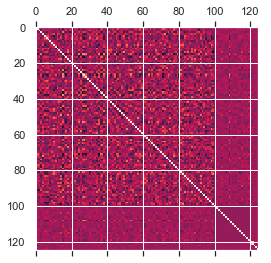

In [60]:
plt.matshow(ResultCorr)
plt.show()

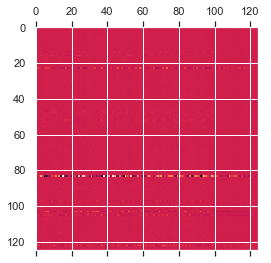

In [61]:
row_sums = ResultCorr.sum(axis=1, keepdims=True)
norm_corr = ResultCorr / row_sums
np.fill_diagonal(norm_corr, 0.005)

plt.matshow(norm_corr)
plt.show()